In [1]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import xarray as xr

### Maths
We want to find the image $I$ that satisfies $\nabla I = G$ where $G$ is a modified image in the gradient domain. 
Hence we want to solve the optimisation problem: 
$$
\text{argmin}_I\left\lvert\left\lvert\begin{pmatrix}\nabla_x\\ \nabla_y\end{pmatrix}I -\begin{pmatrix}G^{(x)}\\G^{(y)}\end{pmatrix}\right\rvert\right\rvert^2\tag{1}
$$
where $\nabla_x$ and $\nabla_y$ are gradient operators. In a discrete sense, $\nabla$ is the forward difference, e.g. in the $x$-direction $I^{(x+1)}_y-I^{x}_y$. We can represent the $x$ gradient over the entire image as a matrix operator $\nabla_x$ and likewise for $\nabla_y$. E.g. in the 3x3 case:
<div>
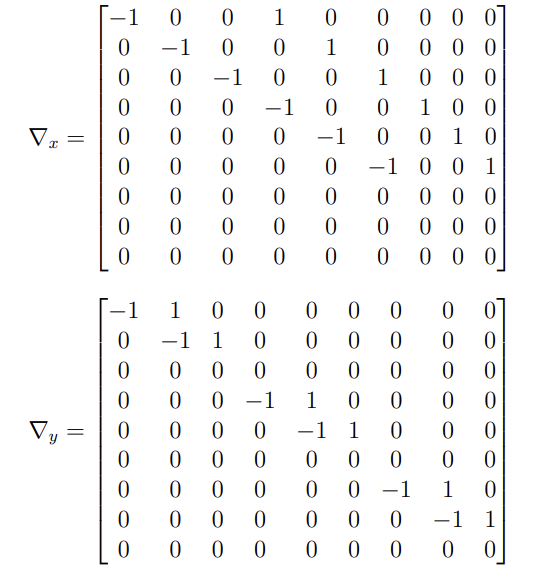
</div>
where $I$ has been flattened into a vector. Forward difference can not be computed on the last pixels (in each dimension). In $\nabla_x$ this is represented in the last 3 rows. In $\nabla_y$, this is represented every third row. For an $m$ dimensional image, 3 would be replaced with $m$. <br> Equation (1) can be represented in matrix form as (see ref): 
$$
(\nabla_x^T\nabla_x + \nabla_y^T \nabla_y)I = \nabla^T_x G^{(x)}+\nabla^T_y G^{(y)}
$$
This is a system of linear equations in the form $Ax = b$ where $A = (\nabla_x^T\nabla_x + \nabla_y^T \nabla_y)$, $x=I$ and $b=\nabla^T_x G^{(x)}+\nabla^T_y G^{(y)}$. Upon solving for $I$, can re-shape into its original dimensions. 
<br>

**Reference:** https://www.cl.cam.ac.uk/teaching/1920/AdvGraphIP/grad_domain.pdf

### Define absolute reconstruction function
The function assumes that you have two gradient channels of a gradient-restored image (e.g. the output channels of the model), as well as the original L4 image. The gradient channels are re-constructed into the absolute domain and subsequently re-scaled based on reference values from the L4 image. Two approaches are provided: 
1. Standard matrix approach: this is a more readable approach based on the above maths. 
2. For large images, the majority of the operator matrices are sparse (i.e., containing mostly zeroes); hence we can use scipy functionalities to collapse matrices into a tabular representation, which is far more computationally efficient. This is used in the `region` notebook.

In [2]:
def absolute_reconstruction(G_x, G_y, l4): 
    ## Re-construct absolute domain from x and y gradient channels
    ## Requires the low-res L4 image as a reference
    
    dim = G_x.shape[0] # dim x dim image
    N = dim**2
    
    # grad_x matrix operator
    grad_x = np.zeros((N,N))
    for i in range(N):
        if (i+1)%dim != 0:
            grad_x[i,i] = -1
            grad_x[i,i+1] = 1
    
    # grad_y matrix operator
    grad_y = np.zeros((N,N))
    for i in range(N):
        if (i+1)//(N-(dim-1)) == 0: 
            grad_y[i,i] = -1 
            grad_y[i,i+dim] = 1
    
    # now we set-up the equation Ax = b
    A = np.matmul(grad_x.transpose(),grad_x) + np.matmul(grad_y.transpose(),grad_y)
    
    G_x_vec = np.ndarray.flatten(G_x)
    G_y_vec = np.ndarray.flatten(G_y)
    b = np.matmul(grad_x.transpose(), G_x_vec) + np.matmul(grad_y.transpose(), G_y_vec)
    
    # solve system of linear equations
    solution = np.linalg.solve(A,b)
    # re-shape flattened vector to (dim x dim) matrix
    reconstructed = np.reshape(solution,(dim,dim))
    # scale values
    l4_min, l4_max = np.min(l4), np.max(l4)
    recon_min, recon_max = np.min(reconstructed), np.max(reconstructed)
    normalized_recon = (reconstructed - recon_min) / (recon_max - recon_min)
    rescaled_reconstructed = normalized_recon * (l4_max - l4_min) + l4_min
    return rescaled_reconstructed

In [3]:
## Sparse approach
def absolute_reconstruction_sp(G_x, G_y, l4): 
    ## Re-construct absolute domain from x and y gradient channels
    ## Requires the low-res L4 image as a reference
    
    dim = G_x.shape[0] # dim x dim image
    N = dim**2
    
    # grad_x sparse matrix operator
    grad_x_data = []
    grad_x_row_indices = []
    grad_x_col_indices = []
    for i in range(N):
        if (i+1) % dim != 0:
            grad_x_data.extend([-1, 1])
            grad_x_row_indices.extend([i, i])
            grad_x_col_indices.extend([i, i+1])
    
    grad_x = sp.csr_matrix((grad_x_data, (grad_x_row_indices, grad_x_col_indices)), shape=(N, N))
    
    # grad_y sparse matrix operator
    grad_y_data = []
    grad_y_row_indices = []
    grad_y_col_indices = []
    for i in range(N):
        if (i+1) // (N-(dim-1)) == 0: 
            grad_y_data.extend([-1, 1])
            grad_y_row_indices.extend([i, i])
            grad_y_col_indices.extend([i, i+dim])
    
    grad_y = sp.csr_matrix((grad_y_data, (grad_y_row_indices, grad_y_col_indices)), shape=(N, N))
    
    # now we set-up the equation Ax = b using sparse matrices
    A = grad_x.transpose().dot(grad_x) + grad_y.transpose().dot(grad_y)
    
    G_x_vec = np.ndarray.flatten(G_x)
    G_y_vec = np.ndarray.flatten(G_y)
    b = grad_x.transpose().dot(G_x_vec) + grad_y.transpose().dot(G_y_vec)
    
    # solve system of linear equations using sparse solver
    solution = splinalg.spsolve(A, b)
    
    # re-shape flattened vector to (dim x dim) matrix
    reconstructed = np.reshape(solution, (dim, dim))
    
    # scale values
    l4_min, l4_max = np.min(l4), np.max(l4)
    recon_min, recon_max = np.min(reconstructed), np.max(reconstructed)
    normalized_recon = (reconstructed - recon_min) / (recon_max - recon_min)
    rescaled_reconstructed = normalized_recon * (l4_max - l4_min) + l4_min
    
    return rescaled_reconstructed

### Example Application
In this example, we:
1. Take a sample image
2. Find the gradient channels of the gradient-restored variable
3. Feed the gradient channels and L4 into the function to retrieve the predicted absolute value reconstruction.
4. Compare the reconstructed-gradient-restored image to the actual gradient-restored image

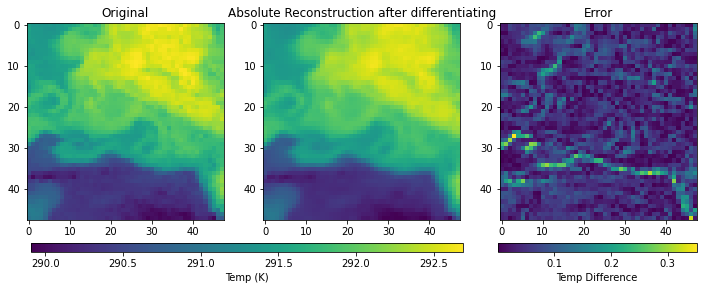

In [16]:
ds = xr.open_dataset('lustre_scratch/data/original_data/absolute/l3_blended_l4_extracts_gR_201703.nc')
gr_x_grad = ds.gRsst.differentiate('x')
gr_y_grad = ds.gRsst.differentiate('y')
# take single sample
randint = np.random.randint(0,len(ds.gRsst))
I = ds.gRsst[randint].data
G_x = gr_x_grad[randint].data
G_y = gr_y_grad[randint].data
I_l4 = ds.sstL4[randint].data

reconstructed = absolute_reconstruction(G_x, G_y, I_l4)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

I_min, I_max = np.min(I), np.max(I)

vmin = min(I_min, np.min(reconstructed))
vmax = max(I_max, np.max(reconstructed))


im1 = ax[0].imshow(I, vmin=vmin, vmax=vmax)
ax[0].set_title('Original')

im2 = ax[1].imshow(reconstructed, vmin=vmin, vmax=vmax)
ax[1].set_title('Absolute Reconstruction after differentiating')

error_image = np.abs(I - reconstructed)
im3 = ax[2].imshow(error_image)
ax[2].set_title('Error')

cbar_ax1 = fig.add_axes([0.13, 0.05, 0.5, 0.03])
fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal', label='Temp (K)')

cbar_ax3 = fig.add_axes([0.67, 0.05, 0.23, 0.03])
fig.colorbar(im3, cax=cbar_ax3, orientation='horizontal', label='Temp Difference')

fig.savefig('plots/final_plots/re_construction')